<a href="https://colab.research.google.com/github/kevinsen-git/TF_Basics/blob/main/02_Modelling_a_Genrated_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generate a fixed sequence of numbers and try finding the simplest, most accurate model 

#### 1. Generate the sequence of 1,000 numbers
#### 2. Split into 80% training + 20% testing 
#### 3. Try various models 
#### 4. Plot the estimates
#### 5. Fine tune the models 
#### 6. Try a bit of over fitting 
#### 7. Redo with some gaps in the data
#### 8. Redo with some added noise in the data 

**[Possible Tuning Methods for models]**

1. ***Change learning rate***
2. ***Change number of epochs***
3. ***Add dense layers***
4. ***Add neurons per layer*** 
5. ***Change activation function***
6. ***Change optimizer***
7. ***Change loss function***
8. ***Use more training data***


In [179]:
# Do the imports and initial setup 
# Need to have the following as global variables 
def my_setup() :
  global tf, np, plt, tfp, pm, pd, re
  import tensorflow as tf 
  import numpy as np 
  import matplotlib.pyplot as plt 
  import tensorflow_probability as tfp
  import pandas as pd 
  from tensorflow.keras.utils import plot_model as pm
  import re 
  tf.random.set_seed(42)
  
 

In [180]:
# Function to show names and versions of the stuff I am using
def my_modules():
  print("tf =",tf.__version__,"| np =",np.__version__,"| tfp =",tfp.__version__
        ,"| pd = ",pd.__version__)
#pip show tensorflow matplotlib numpy
#pip list 

In [181]:
# Function to do basic stats on a simple tensor 
def my_stats(data):
  print("Min = ",tf.math.reduce_min(data))
  print("Q25 = ",tfp.stats.percentile(data, 25))
  print("Q50 = ",tfp.stats.percentile(data, 50))
  print("Q90 = ",tfp.stats.percentile(data, 90))
  print("Max= ",tf.math.reduce_max(data))
  print("Mean = ",tf.math.reduce_mean(data))
  print("Std Dev = ",tfp.stats.stddev(data))
  print()
  # Do histogram 
  plt.hist(data)

In [182]:
# Function to do basic stats on a simple tensor 
def my_stats2(data):
  print("Min=",tf.math.reduce_min(data).numpy().round(2),"Q25=",tfp.stats.percentile(data, 25).numpy().round(2),"Q50=",tfp.stats.percentile(data, 50).numpy().round(2),
        "Q90=",tfp.stats.percentile(data, 90).numpy().round(2))
  print("Max=",tf.math.reduce_max(data).numpy().round(2),"Mean=",tf.math.reduce_mean(data).numpy().round(2),"StdDev=",tf.squeeze(tfp.stats.stddev(data)).numpy().round(2))
  print()
  # Do histogram 
  plt.hist(data)

In [183]:
# Function to calculate the mean absolute error and the mean squared error 
def my_mae_mse(y_test,y_pred):
  mae = tf.metrics.mean_absolute_error(y_test, tf.squeeze(y_pred))
  mse = tf.metrics.mean_squared_error(y_test, tf.squeeze(y_pred))
  print ('mae = ',mae.numpy().round(2),'| mse = ',mse.numpy().round(2))
  return mae.numpy().round(2), mse.numpy().round(2)

In [184]:
# Create plotting function
def plot_predictions(train_data,train_labels,test_data,test_labels,predictions):
  # The doc string 
  """
  Plots the training data and the ground truth vs the prediction
  """
  # Ctrl + Shift + space - will show the docstring in colab jupyter notebooks 
  plt.figure(figsize=(15,10))
  # Plot the training data in blue 
  plt.scatter(train_data,train_labels,c='b',label='Training Data')
  # Plot the test data in green
  plt.scatter(test_data,test_labels,c='g',label="Test data")
  # Plot the predictions in red 
  plt.scatter(test_data,predictions,c='r', label="Predictions")
  # Show legend
  plt.legend()

In [185]:
def my_models_init():
  global all_results
  all_results = pd.DataFrame(columns=['name','mae','mse','layers','params','epochs'])
  all_results['mae'] = all_results['mae'].map('{:,.2f}'.format) 
  all_results['mse'] = all_results['mse'].map('{:,.2f}'.format)
  all_results['layers'] = all_results['layers'].map('{:,.0f}'.format) 
  all_results['params'] = all_results['params'].map('{:,.0f}'.format) 
  all_results['epochs'] = all_results['epochs'].map('{:,.0f}'.format) 
   

In [186]:
def my_model_add(vals):
  global all_results
  df = pd.DataFrame(vals,columns=['name','mae','mse','layers','params','epochs'])
  df['mae'] = df['mae'].map('{:,.2f}'.format) 
  df['mse'] = df['mse'].map('{:,.2f}'.format)
  df['layers'] = df['layers'].map('{:,.0f}'.format) 
  df['params'] = df['params'].map('{:,.0f}'.format) 
  df['epochs'] = df['epochs'].map('{:,.0f}'.format) 
  all_results = all_results.append(df,ignore_index = True)
  #print(df)
  #print(all_results)


In [187]:
def my_model_info(model, fitted, mae, mse):
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  summ_string = "\n".join(stringlist)
  #print(summ_string) # entire summary in a variable

  table = stringlist[1:-4][1::2] # take every other element and remove appendix

  new_table = []
  for entry in table:
    entry = re.split(r'\s{2,}', entry)[:-1] # remove whitespace
    new_table.append(entry)
  df = pd.DataFrame(new_table[1:], columns=new_table[0])
  #print(df.head())
  layers = len(df.index)
  params = sum(df['Param #'].astype(int))
  n_epochs = len(fitted.history['loss'])
  model_results=[[model.name,mae,mse,layers,params,n_epochs]]
  my_model_add(model_results)
  


In [188]:
# Init all 
my_setup()
my_modules()
my_models_init()

tf = 2.6.0 | np = 1.19.5 | tfp = 0.14.1 | pd =  1.1.5


In [189]:
# Generate the dataset 
# X_train, y_train, X_test, y_test 
# Using tf.range

X = tf.range(start=1.0, limit=3000, delta=2)
y = tf.range(start=100.0, limit=3100, delta=2)
# y= X + 100
X.shape, y.shape


(TensorShape([1500]), TensorShape([1500]))

In [190]:
# Now split into training 1000 and test 500 
# Preserve the order initially 
X_train = X[:1000]
y_train = y[:1000]
X_test = X[1000:]
y_test = y[1000:]



Min =  tf.Tensor(1.0, shape=(), dtype=float32)
Q25 =  tf.Tensor(501.0, shape=(), dtype=float32)
Q50 =  tf.Tensor(1001.0, shape=(), dtype=float32)
Q90 =  tf.Tensor(1799.0, shape=(), dtype=float32)
Max=  tf.Tensor(1999.0, shape=(), dtype=float32)
Mean =  tf.Tensor(1000.0, shape=(), dtype=float32)
Std Dev =  tf.Tensor(577.35, shape=(), dtype=float32)

Min =  tf.Tensor(2001.0, shape=(), dtype=float32)
Q25 =  tf.Tensor(2251.0, shape=(), dtype=float32)
Q50 =  tf.Tensor(2501.0, shape=(), dtype=float32)
Q90 =  tf.Tensor(2899.0, shape=(), dtype=float32)
Max=  tf.Tensor(2999.0, shape=(), dtype=float32)
Mean =  tf.Tensor(2500.0, shape=(), dtype=float32)
Std Dev =  tf.Tensor(288.67456, shape=(), dtype=float32)

Min =  tf.Tensor(100.0, shape=(), dtype=float32)
Q25 =  tf.Tensor(600.0, shape=(), dtype=float32)
Q50 =  tf.Tensor(1100.0, shape=(), dtype=float32)
Q90 =  tf.Tensor(1898.0, shape=(), dtype=float32)
Max=  tf.Tensor(2098.0, shape=(), dtype=float32)
Mean =  tf.Tensor(1099.0, shape=(), dtype=fl

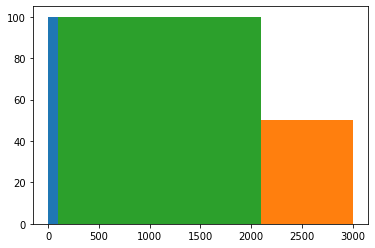

In [191]:
# Show basic stats
my_stats(X_train)
my_stats(X_test)
my_stats(y_train)



mae =  377.09 | mse =  143231.48


,name,mae,mse,layers,params,epochs
0,sequential_19,377.09,"143,231.48",1,2,10


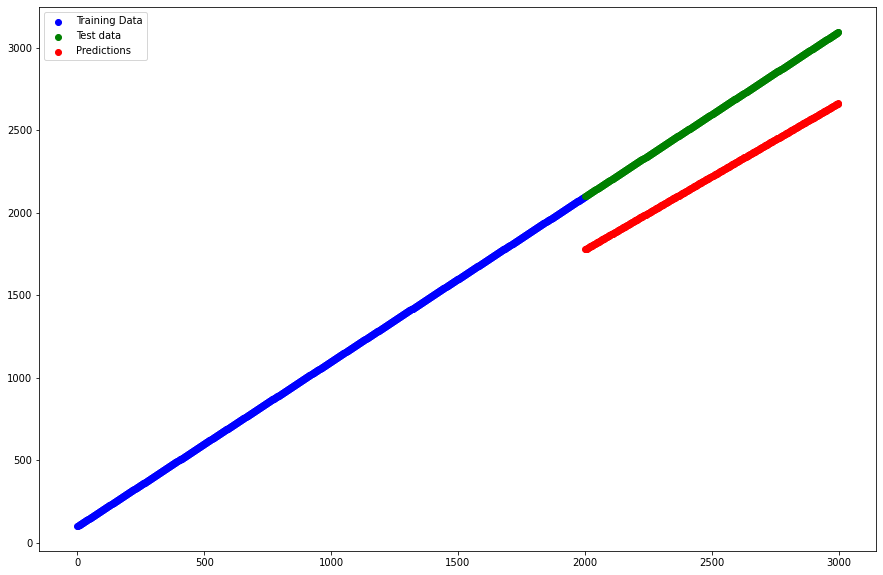

In [192]:
# Fit the first model 
# One layer 
# With smell/default learning rate it is TERRIBLE !
# Create the model
model_1 = tf.keras.Sequential()
#model.add(tf.keras.layers.Dense(100,activation="relu"))
model_1.add(tf.keras.layers.Dense(1))

# Compile the model
model_1.compile(loss=tf.keras.losses.mae, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ["mae"])

# Fit the model
r = model_1.fit(X_train, y_train, epochs = 10, verbose=0)

# Predict and plot 
y_pred = model_1.predict(X_test)

# Summary 
# Show basic stats
#my_stats2(X_train)
#my_stats2(X_test)
#my_stats2(y_train)
#my_stats2(y_test)
#my_stats2(y_pred)
# Get mae_mse
mae, mse = my_mae_mse(y_test, y_pred)

mae, mse
# Plot 
plot_predictions(X_train, y_train, X_test, y_test, y_pred)

# Update central table 
my_model_info(model_1,r,mae, mse)
all_results


mae =  81.65 | mse =  7090.43


,name,mae,mse,layers,params,epochs
0,sequential_19,377.09,"143,231.48",1,2,10
1,sequential_20,81.65,"7,090.43",1,2,10


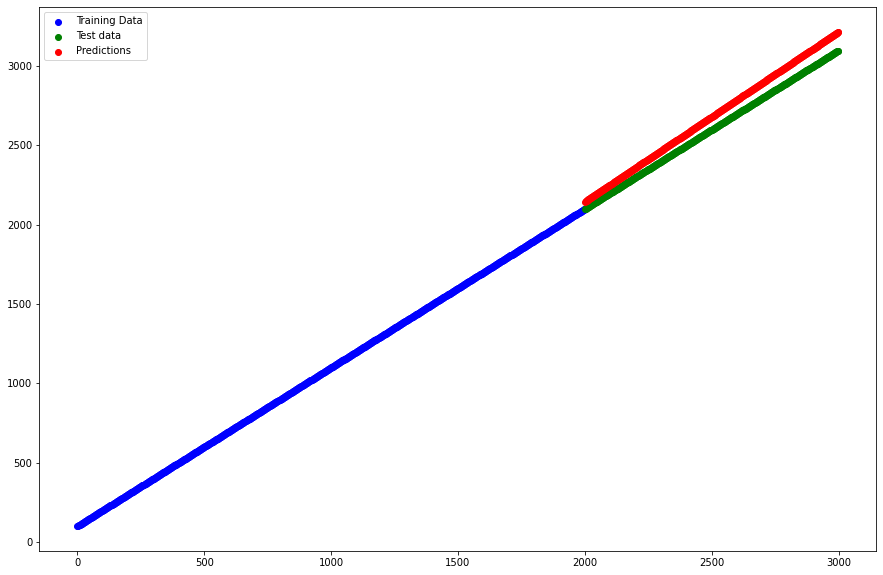

In [193]:
# Fit the second model 
# One layer 
# With large learning rate it is much better 
# Create the model
model_2 = tf.keras.Sequential()
#model.add(tf.keras.layers.Dense(100,activation="relu"))
model_2.add(tf.keras.layers.Dense(1))

# Compile the model
model_2.compile(loss=tf.keras.losses.mae, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ["mae"])

# Fit the model
r = model_2.fit(X_train, y_train, epochs = 10, verbose=0)

# Predict and plot 
y_pred = model_2.predict(X_test)

# Get mae_mse
mae, mse = my_mae_mse(y_test, y_pred)

mae, mse
# Plot 
plot_predictions(X_train, y_train, X_test, y_test, y_pred)

# Update central table 
my_model_info(model_2,r,mae, mse)
all_results




mae =  14945.9 | mse =  226374270.0


,name,mae,mse,layers,params,epochs
0,sequential_19,377.09,"143,231.48",1,2,10
1,sequential_20,81.65,"7,090.43",1,2,10
2,sequential_21,"14,945.90","226,374,272.00",1,2,10


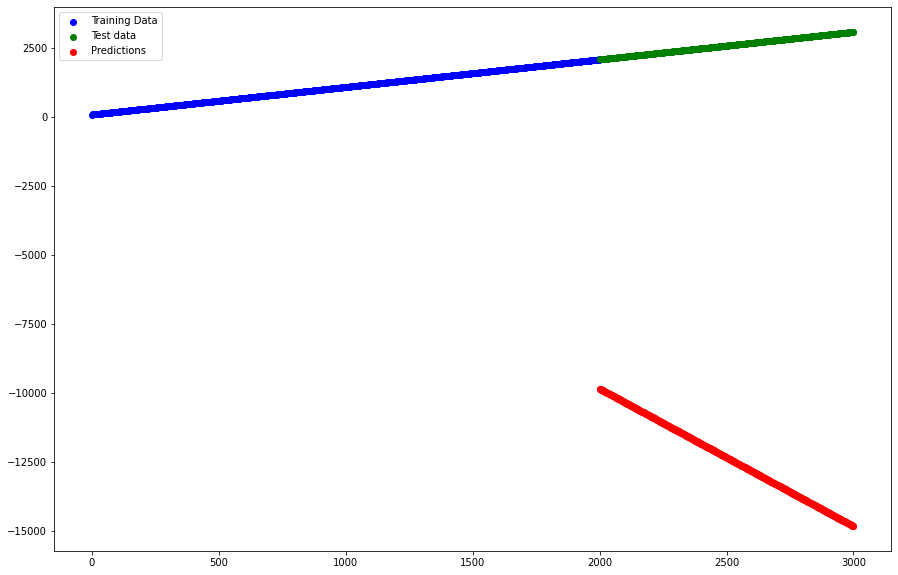

In [194]:
# Fit the third model 
# One layer 
# With large learning rate it is much better 
# Create the model
model_3 = tf.keras.Sequential()
#model_3.add(tf.keras.layers.Dense(100,activation="relu"))
model_3.add(tf.keras.layers.Dense(1))

# Compile the model
model_3.compile(loss=tf.keras.losses.mae, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=100.0),
              metrics = ["mae"])

#Fit the model
r = model_3.fit(X_train, y_train, epochs = 10, verbose=0)

# Predict and plot 
y_pred = model_3.predict(X_test)

# Get mae_mse
mae, mse = my_mae_mse(y_test, y_pred)

mae, mse
# Plot 
plot_predictions(X_train, y_train, X_test, y_test, y_pred)

# Update central table 
my_model_info(model_3,r,mae, mse)
all_results



mae =  9.35 | mse =  95.78


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f6018190b10>>

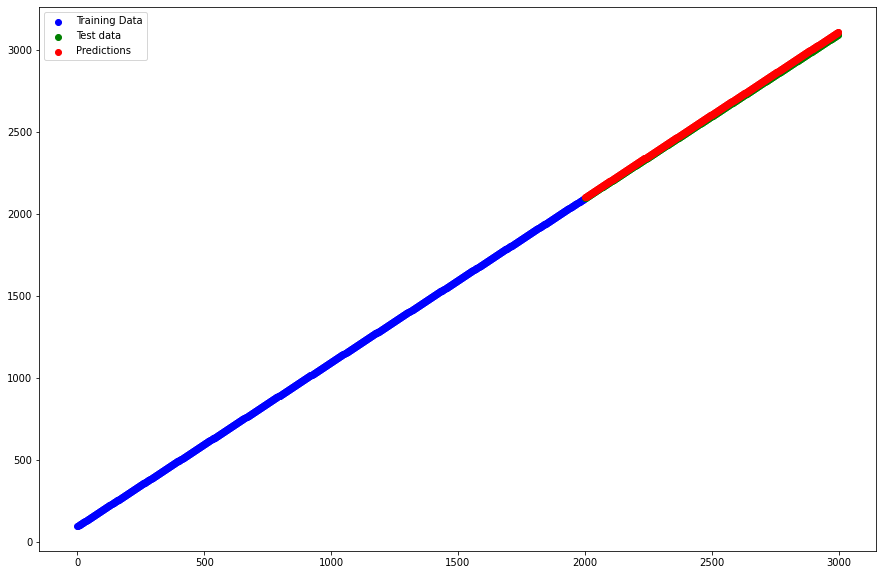

In [195]:
# Fit the fourth model 
# One layer 
# With large learning rate it is much better 
# Create the model
model_4 = tf.keras.Sequential()
#model_4.add(tf.keras.layers.Dense(100,activation="relu"))
model_4.add(tf.keras.layers.Dense(1))

# Compile the model
model_4.compile(loss=tf.keras.losses.mae, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ["mae"])

#Fit the model
r = model_4.fit(X_train, y_train, epochs = 300, verbose=0)

# Predict and plot 
y_pred = model_4.predict(X_test)

# Get mae_mse
mae, mse = my_mae_mse(y_test, y_pred)

mae, mse
# Plot 
plot_predictions(X_train, y_train, X_test, y_test, y_pred)

# Update central table 
my_model_info(model_4,r,mae, mse)
all_results


# Model Summry
model_4.summary



Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 1)                 2         
_________________________________________________________________
Hidden_Layer (Dense)         (None, 100)               200       
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 101       
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
mae =  47.42 | mse =  2275.13


,name,mae,mse,layers,params,epochs
0,sequential_19,377.09,"143,231.48",1,2,10
1,sequential_20,81.65,"7,090.43",1,2,10
2,sequential_21,"14,945.90","226,374,272.00",1,2,10
3,sequential_22,9.35,95.78,1,2,300
4,model_5,47.42,"2,275.13",3,303,300


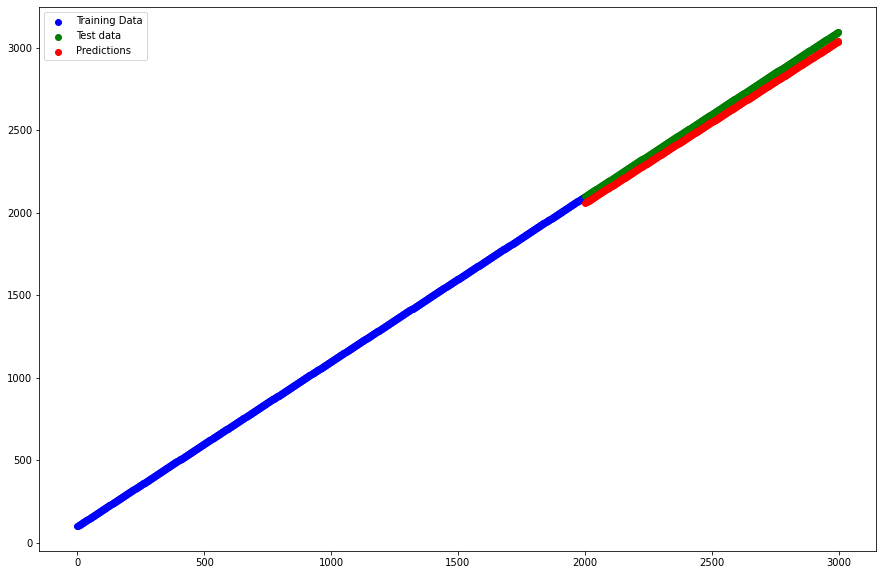

In [196]:
# Do another model, add input_shape and show model details _before_ fitting 

# Create the nodel 
model_5 = tf.keras.Sequential(name="model_5")
model_5.add(tf.keras.layers.Dense(1, input_shape=[1], name='Input_Layer'))
model_5.add(tf.keras.layers.Dense(100, activation="relu", name="Hidden_Layer"))
#model_5.add(tf.keras.layers.Dense(3, input_shape=[1]))
model_5.add(tf.keras.layers.Dense(1, name="Output_Layer"))

# Compile the model 
model_5.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=tf.keras.metrics.mae)

# Get the model summary 
model_5.summary()

# Why are there 303 instead of 300 parameters ?
# Becuase of the 3 in the output layer 
pm(model=model_5,show_shapes=True)

#Fit the model
r = model_5.fit(X_train, y_train, epochs = 300, verbose=0)

# Predict and plot 
y_pred = model_5.predict(X_test)

# Get mae_mse
mae, mse = my_mae_mse(y_test, y_pred)

mae, mse
# Plot 
plot_predictions(X_train, y_train, X_test, y_test, y_pred)

# Update central table 
my_model_info(model_5,r,mae, mse)
all_results




In [197]:
# Put this into a function 
# Name everything - model and the layers as well 
# Make 2 pandas data frames
# One with a model summary 
# One with the model details for each model 
# Soooo Cool 

